## Goal
* Predict average transaction size (transaction_aos) per customer.


## Table of Contents

* Import Packages
* Read Train and Test CSV files
* Examine density plots for target metrics
* Make copies of train and test
* Train histogram of all features
* Log transform of target variable and visualized
* Identify columns with constants and drop from train and test
* Drop generic columns from train and test
* Identify categorical features/columns
* Transform Gender: One Hot Encoding
* Transform categorical to numeric ordinal columns & drop redundant columns
* Define target variable and remove target variables from X_train and X_test
* Feature Selection: Identify highly correlated features and remove
* Drop Data Leakage Related Features to Target 
* Build Linear Model
* Test for Residual Normality
* Build Random Forest Regression Model

## Import Packages

In [1]:
%matplotlib inline
import os
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Read Train and Test CSV files

In [2]:
train_file = 'train_starbucks.csv.gz'
test_file = 'test_starbucks.csv.gz'

train_file_gzip = os.path.join('../data', train_file)
test_file_gzip = os.path.join('../data', test_file)

train = pd.read_csv(train_file_gzip, compression='gzip')
test = pd.read_csv(test_file_gzip, compression='gzip')

print(train.shape)
print(test.shape)

(11390, 53)
(5610, 53)


## Examine density plots for target metrics

Text(0, 0.5, 'Density')

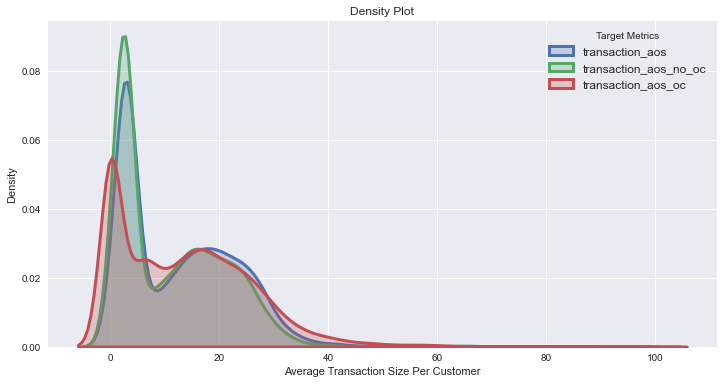

In [3]:
# kernel density plots for transaction_aos, transaction_aos_oc, transaction_aos_no_oc
X_train = train.copy()
plt.figure(figsize=(12,6))
targets = ['transaction_aos', 'transaction_aos_no_oc', 'transaction_aos_oc']

for target in targets:
    sns.distplot(X_train[X_train[target] < 100][target], 
                 hist = False, 
                 kde = True,
                 kde_kws = {'linewidth': 3, 'shade': True},
                 label = target)
    
plt.legend(prop = {'size': 12}, title = 'Target Metrics')
plt.title('Density Plot')
plt.xlabel('Average Transaction Size Per Customer')
plt.ylabel('Density')

## Make copies of train and test

In [4]:
X_train = train.copy()
X_test = test.copy()

## Train histogram of all features

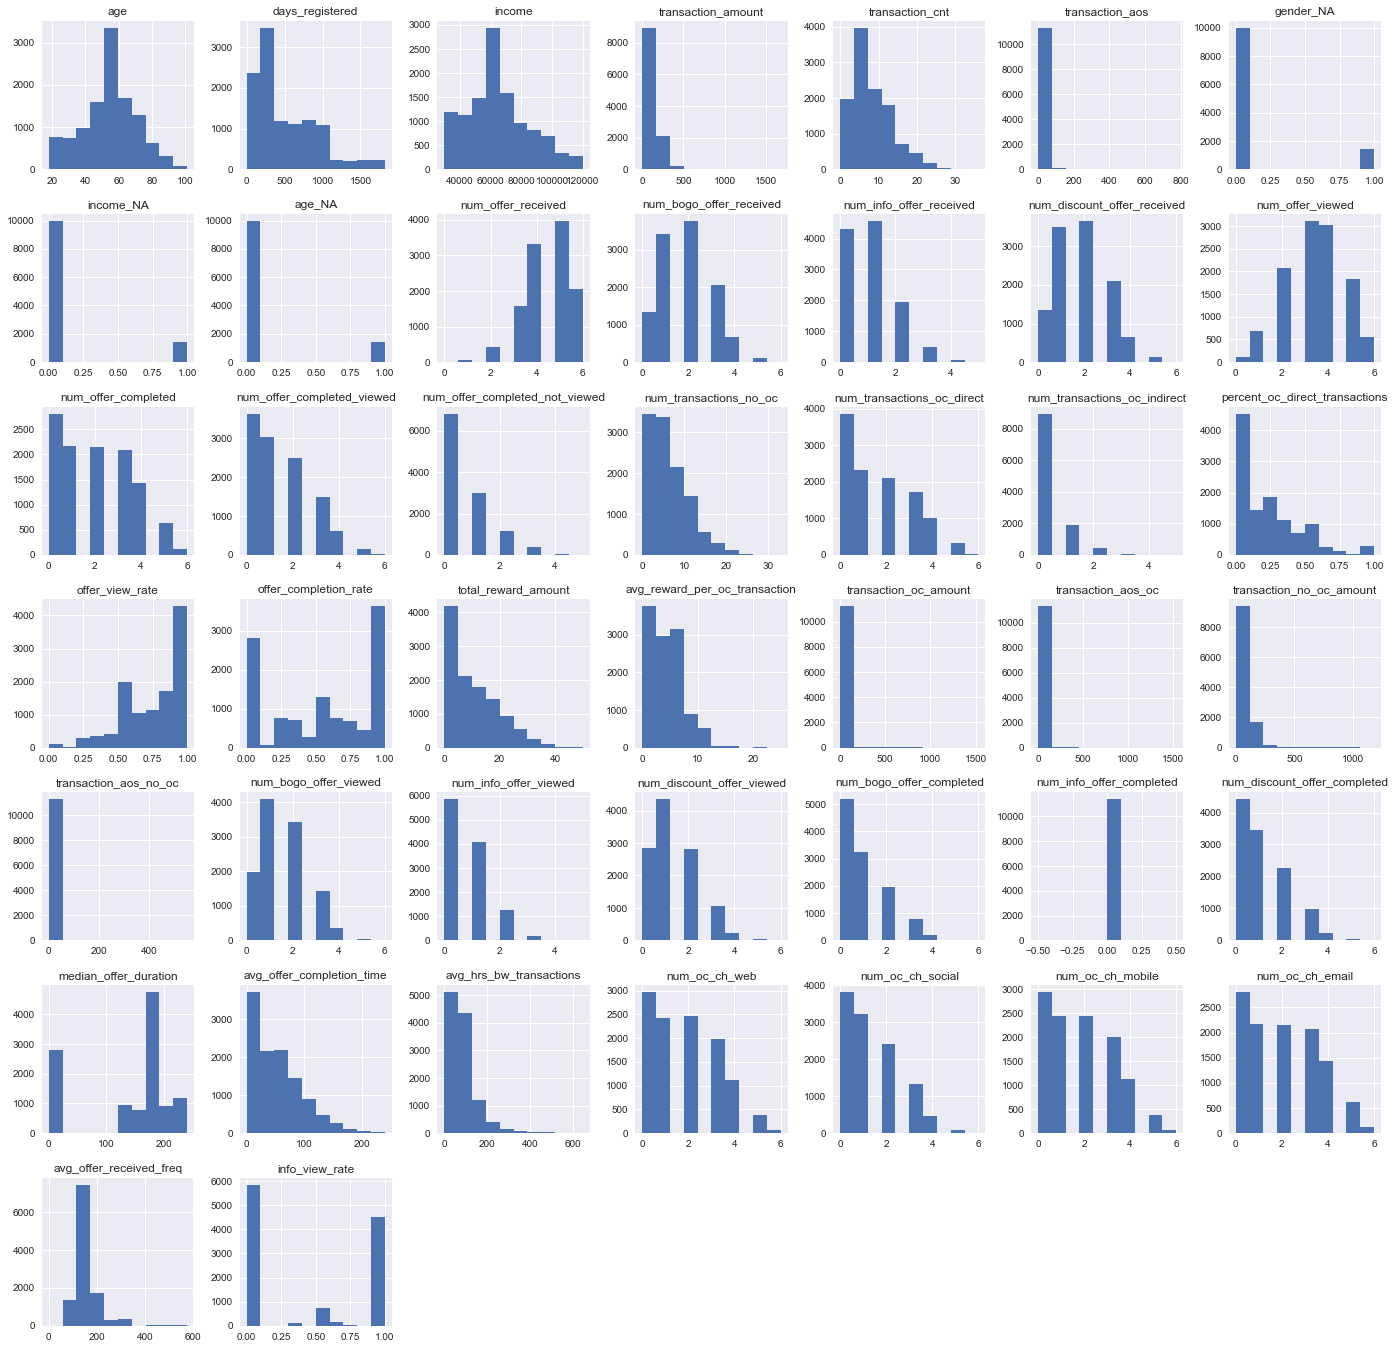

In [5]:
X_train.hist(figsize=(24,24))
plt.show()

In [6]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# plot histogram and Q-Q plot
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    
    plt.show()

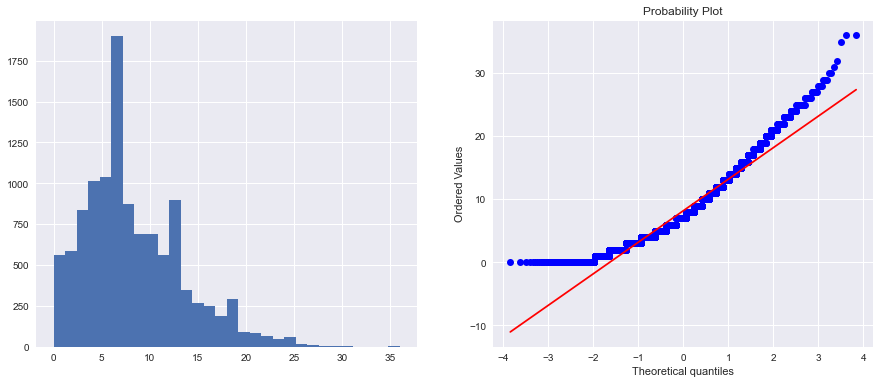

In [7]:
# diagnotics plots 
diagnostic_plots(X_train, variable='transaction_cnt')

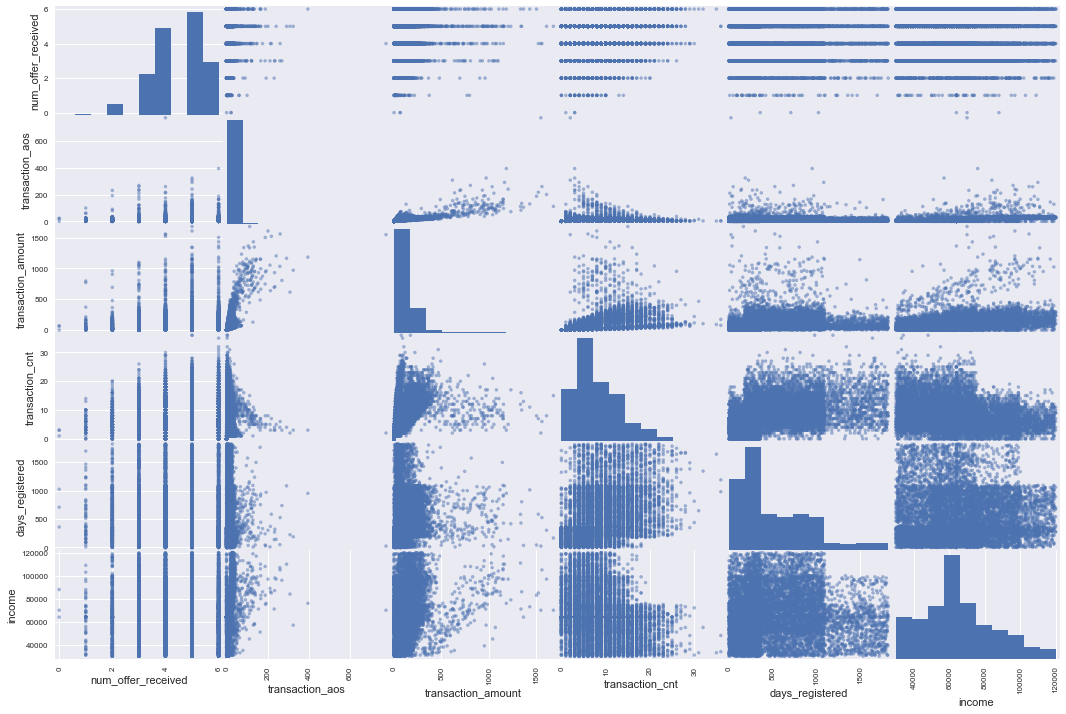

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_train[['num_offer_received','transaction_aos','transaction_amount',
                        'transaction_cnt','days_registered','income']], figsize=(18, 12));

## Log transform of target variable and visualized

<AxesSubplot:>

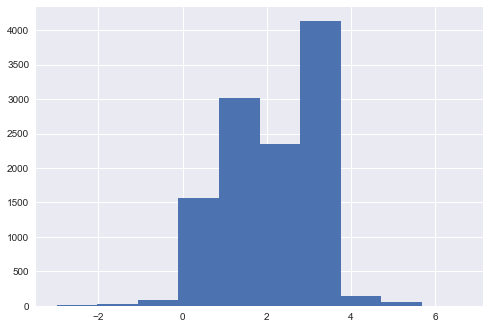

In [9]:
log_transaction_aos_list = list(np.log(X_train.transaction_aos))
log_transaction_aos = pd.DataFrame({'log_transaction_aos': log_transaction_aos_list})

log_transaction_aos['log_transaction_aos'] = log_transaction_aos['log_transaction_aos'].replace(-np.inf,0).replace(np.inf,0)
log_transaction_aos['log_transaction_aos'].hist(bins=10)

<AxesSubplot:xlabel='log_transaction_aos', ylabel='Density'>

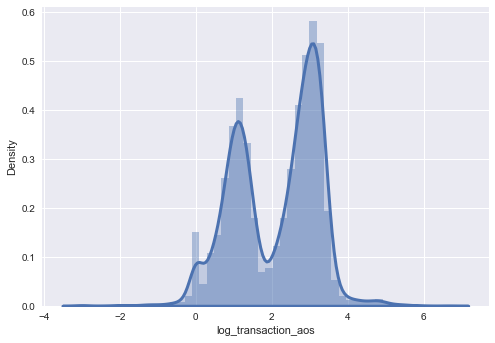

In [10]:
sns.distplot(log_transaction_aos['log_transaction_aos'], 
             hist = True, 
             kde = True,
             kde_kws = {'linewidth': 3, 'shade': True},
             label = target)

## Identify columns with constants and drop from train and test

In [11]:
# drop columns with constants
DROP_CONSTANT_COLUMNS = []

for column in X_train.columns:
    if X_train[column].nunique() == 1:
        print(column)
        DROP_CONSTANT_COLUMNS.append(column)

X_train.drop(columns=DROP_CONSTANT_COLUMNS, inplace = True)
X_test.drop(columns=DROP_CONSTANT_COLUMNS, inplace = True)

num_info_offer_completed


## Drop generic columns from train and test

In [12]:
DROP_GENERIC_COLUMNS = ['customer_id', 'gender_NA', 'income_NA', 'age_NA']
X_train.drop(columns=DROP_GENERIC_COLUMNS, inplace=True)
X_test.drop(columns=DROP_GENERIC_COLUMNS, inplace=True)

## Identify categorical features/columns

In [13]:
X_train.select_dtypes(include='object').columns

Index(['gender', 'age_quantile_range', 'age_quantile_label', 'date_registered',
       'days_reg_quantile_range', 'days_reg_quantile_label',
       'income_quantile_range', 'income_quantile_label'],
      dtype='object')

## Transform Gender: One Hot Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Re-label 'O' to 'Missing' for gender
X_train['gender'] = X_train['gender'].apply(lambda x: 'Missing' if x == 'O' else x)
X_test['gender'] = X_test['gender'].apply(lambda x: 'Missing' if x == 'O' else x)

# integer encode
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(X_train.gender)
test_integer_encoded = label_encoder.transform(X_test.gender)

# binary encode
n_train = len(train_integer_encoded)
n_test = len(test_integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
train_integer_encoded_reshape = train_integer_encoded.reshape(n_train, 1)
test_integer_encoded_reshape = test_integer_encoded.reshape(n_test, 1)

train_onehot_encoded = onehot_encoder.fit_transform(train_integer_encoded_reshape)
test_onehot_encoded = onehot_encoder.transform(test_integer_encoded_reshape)


In [15]:
# generate column names for gender feature
# append one-hot-encoded gender columns to X_train and X_test

train_label_mapping = [item for item in zip(train_integer_encoded, np.array(X_train.gender))]
train_label_mapping = sorted(set(train_label_mapping))
train_column_names = ['gender_' + i[1] for i in train_label_mapping]    
train_ohe_gender = pd.DataFrame(train_onehot_encoded, columns=train_column_names)
X_train = pd.concat([X_train, train_ohe_gender], axis=1)

test_label_mapping = [item for item in zip(test_integer_encoded, np.array(X_test.gender))]
test_label_mapping = sorted(set(test_label_mapping))
test_column_names = ['gender_' + i[1] for i in test_label_mapping]
test_ohe_gender = pd.DataFrame(test_onehot_encoded, columns=test_column_names)
X_test = pd.concat([X_test, test_ohe_gender], axis=1)


## Transform categorical to numeric ordinal columns & drop redundant columns

In [16]:
# ordinal (categorical) encoding
DROP_REDUNDANT_COLUMNS = ['gender', 'age_quantile_range', 'date_registered', 
                          'age_quantile_label', 'days_reg_quantile_label','income_quantile_label', 
                          'days_reg_quantile_range', 'income_quantile_range']

ORDINAL_COLUMNS = ['age_quantile_label', 'days_reg_quantile_label','income_quantile_label']

# integer encode
label_encoder = LabelEncoder()

for column in ORDINAL_COLUMNS:
    train_labels = X_train[column]
    test_labels = X_test[column]
    
    train_integer_encoded = label_encoder.fit_transform(train_labels)
    test_integer_encoded = label_encoder.transform(test_labels)
    
    adj_column = column + '_enc'
    
    train_column = pd.DataFrame(train_integer_encoded, columns=[adj_column])
    test_column = pd.DataFrame(test_integer_encoded, columns=[adj_column])
    
    X_train = pd.concat([X_train, train_column], axis=1)
    X_test = pd.concat([X_test, test_column], axis=1)

X_train.drop(columns=DROP_REDUNDANT_COLUMNS, inplace=True)
X_test.drop(columns=DROP_REDUNDANT_COLUMNS, inplace=True)

## Define target variable and remove target variables from X_train and X_test

In [17]:
y_train = X_train.transaction_aos
y_test = X_test.transaction_aos

DROP_TARGET_COLUMNS = ['transaction_aos', 'transaction_aos_oc', 'transaction_aos_no_oc']
X_train.drop(columns=DROP_TARGET_COLUMNS, inplace=True)
X_test.drop(columns=DROP_TARGET_COLUMNS, inplace=True)


In [18]:
print(X_train.shape)
print(X_test.shape)

(11390, 43)
(5610, 43)


## Feature Selection: Identify highly correlated features and remove

In [19]:
cor_matrix = X_train.corr().abs()

Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements. So we are selecting the upper traingular.

In [20]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['num_transactions_no_oc', 'num_oc_ch_web', 'num_oc_ch_mobile', 'num_oc_ch_email']


In [21]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

## Drop Data Leakage Related Features to Target 
* transaction_amount
* transaction_cnt
* transaction_oc_amount
* transaction_no_oc_amount
* avg_reward_per_oc_transaction
* percent_oc_direct_transactions
* num_transactions_oc_direct
* num_transactions_oc_indirect

In [22]:
X_train.drop(columns=['transaction_amount', 'transaction_oc_amount', 'transaction_no_oc_amount', 
                      'transaction_cnt', 'avg_reward_per_oc_transaction', 'percent_oc_direct_transactions', 
                      'num_transactions_oc_direct', 'num_transactions_oc_indirect'], inplace=True)

X_test.drop(columns=['transaction_amount','transaction_oc_amount', 'transaction_no_oc_amount', 
                      'transaction_cnt', 'avg_reward_per_oc_transaction','percent_oc_direct_transactions', 
                      'num_transactions_oc_direct', 'num_transactions_oc_indirect'], inplace=True)

## Build Linear Model

In [23]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)

# instantiate a linear model
linreg = LinearRegression()

# train the model
linreg.fit(scaler.transform(X_train), y_train)

# make predictions on the train set and calculate
# the mean squared error
print('Train set')
pred = linreg.predict(scaler.transform(X_train))
print('MSE: {}'.format(mean_squared_error(y_train, pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, pred))))
print('r2: {}'.format(r2_score(y_train, pred)))
print()

# make predictions on the test set and calculate
# the mean squared error
print('Test set')
pred = linreg.predict(scaler.transform(X_test))
print('MSE: {}'.format(mean_squared_error(y_test, pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, pred))))
print('r2: {}'.format(r2_score(y_test, pred)))
print()


Train set
MSE: 246.41595720574216
RMSE: 15.697641772117944
r2: 0.28893777678768606

Test set
MSE: 247.15164437473783
RMSE: 15.721057355494185
r2: 0.28867775075519464



## Test for Residual Normality

<AxesSubplot:xlabel='transaction_aos', ylabel='Count'>

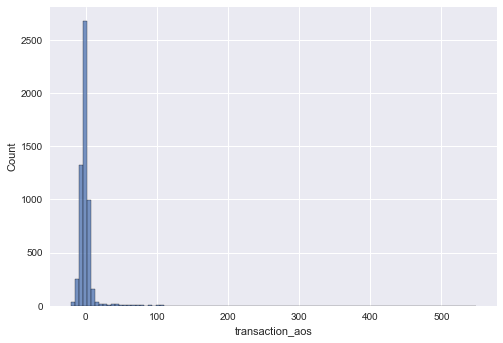

In [24]:
# calculate the residuals
error = y_test - pred

# check using histogram to determine if the residuals are normally distributed with mean value at 0
sns.histplot(error, bins=100)

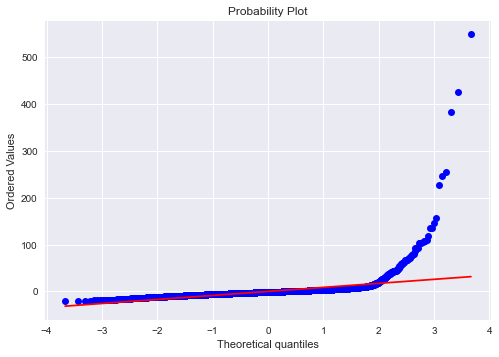

In [25]:
# we can better visualize residuals distribution with 
# a Q-Q plot. If the residuals are normally distributed
# the dots should adjust to the 45 degree line

stats.probplot(error, dist="norm", plot=plt)
plt.show()

## Build Random Forest Regression Model

In [26]:
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=0)
print(rf_estimator.get_params())

rf_estimator.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


RandomForestRegressor(random_state=0)

In [27]:
rf_estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [28]:
y_pred = rf_estimator.predict(X_test)

In [29]:
mse = mean_squared_error(y_test, y_pred)

print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('r2: {}'.format(r2_score(y_test, y_pred)))

# MSE: 13.01723366820678
# RMSE: 3.607940363726482
# r2: 0.9626998656567011

MSE: 274.99907404456326
RMSE: 16.583096033146624
r2: 0.20853061534551642


<AxesSubplot:xlabel='transaction_aos', ylabel='Count'>

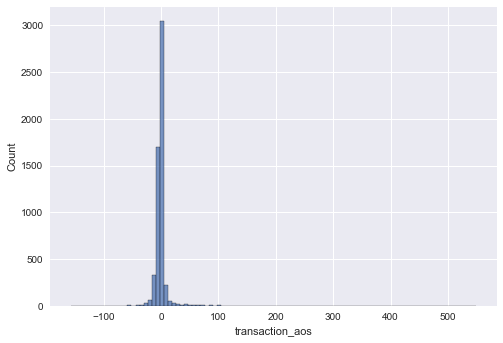

In [30]:
# calculate the residuals
error = y_test - y_pred
sns.histplot(error, bins=100)

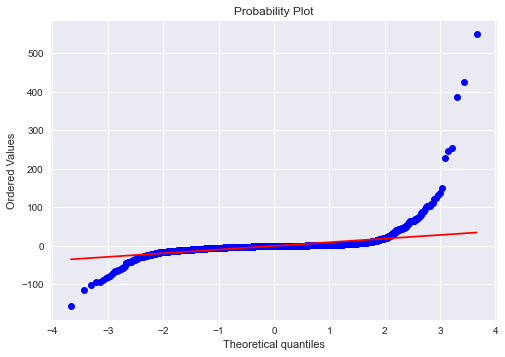

In [31]:
stats.probplot(error, dist="norm", plot=plt)
plt.show()

In [32]:
rf_estimator.feature_importances_

array([0.06573402, 0.1081336 , 0.25722608, 0.01106347, 0.00926407,
       0.00932321, 0.01556962, 0.01366639, 0.00921067, 0.00951183,
       0.01136262, 0.01301797, 0.07918853, 0.03280578, 0.00943023,
       0.01071112, 0.0143647 , 0.01119818, 0.00950158, 0.01559312,
       0.05826121, 0.08578421, 0.00892756, 0.08091334, 0.00574924,
       0.00458152, 0.0052945 , 0.00321506, 0.00995249, 0.01351297,
       0.00793112])

In [33]:
def feature_ranking(train_data, n_features, feature_importance_scores):
    """
    train_data: training pandas dataframe data
    n_features: an integer; number of features in X_train
    feature_importance_scores: numpy ndarray from sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    feature_importances = {}
    for idx in range(n_features):
        key = train_data.columns[idx]
        val = feature_importance_scores[idx]
        feature_importances[key] = val

    important_features = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
    ranked_features = important_features.sort_values('importance', ascending=False)
    
    return ranked_features

In [34]:
feature_ranking(X_train, len(X_train.columns), rf_estimator.feature_importances_)

,importance
income,0.257226
days_registered,0.108134
avg_hrs_bw_transactions,0.085784
avg_offer_received_freq,0.080913
offer_completion_rate,0.079189
age,0.065734
avg_offer_completion_time,0.058261
total_reward_amount,0.032806
median_offer_duration,0.015593
num_discount_offer_received,0.015570
